In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal # To evaluate pdf for normal
from scipy.stats import random_correlation  # To generate Covariance matrix

%matplotlib inline

In [2]:
EPS = 1e-10  # Used for numerical stability

In [3]:
# Utility functions

def get_init_means(X: np.ndarray, k: int):
    """Select k random points from the input sample X"""
    positions = np.random.permutation(X.shape[0])[:k]
    return [i for i in X[positions]]

def get_init_pi(k: int):
    """Returns a list of random values for PI"""
    pi = np.random.randint(0,10,size=k)
    return (pi / np.sum(pi,dtype=float)).tolist()

def get_sigma(dim):
    """Returns a positive semi-definite random matrix"""
    t = np.random.rand(dim)
    t = (t / np.sum(t)) * dim
    return random_correlation.rvs(t)

def get_init_sigma(dim, k):
    return [get_sigma(dim) for i in range(k)]

def log_likelihood(X, meanlist, sigmalist, pilist):
    """Calculate log likelihood of data given theta"""
    gamma = np.zeros((X.shape[0], len(meanlist)))
    for i in range(len(meanlist)):
        probs = multivariate_normal.pdf(X, meanlist[i], sigmalist[i], allow_singular=True)
        gamma[:, i] = probs * pilist[i]
    return np.sum(np.log(np.sum(gamma, axis=1)))

def check_convergence(X, old_ml, ml, old_sl, sl, old_pl, pl, threshold):
    """Checks if improvement in log likelihood is less than threshold"""
    llh1 = log_likelihood(X, old_ml, old_sl, old_pl)
    llh2 = log_likelihood(X, ml, sl, pl)
    diff = np.abs(llh1 - llh2)

    # Uncomment the lines below to see the value of parameters after each iteration
    # print("Mean: ", ml)
    # print("Sigma: ", sl)
    # print("PI: ", pl)
    print("Improvement in log likelihood :", diff)
    return diff <= threshold

In [4]:
class GMM:
    def __init__(
        self,
        k: int,
        *,
        threshold: float = 0.0001,
        epochs: int = 1000):
        """
        Args:
            k: No. of clusters.
            threshold: Min error before stopping
            epochs: Max iterations before stopping
        """
        self.k = k
        self.threshold = threshold
        self.epochs = epochs
        self.meanlist = []
        self.sigmalist = []
        self.pilist = []

    def fit(self, X: np.ndarray):
        # Loop till one of the following is achieved:
        # Convergence or Max epochs
        assert isinstance(X, np.ndarray)
        assert X.ndim == 2
        X = X.T
        self.N, self.dim = X.shape
        assert self.N >= self.k

        # Initialization
        self.meanlist = get_init_means(X, self.k)
        self.pilist = get_init_pi(self.k)
        self.sigmalist = get_init_sigma(self.dim, self.k)


        for epoch in range(self.epochs):
            print(f'\nEpoch: {epoch}')

            meanlist = []
            sigmalist = []
            pilist = []

            # Calculate gamma matrix (N * k)
            gamma = np.zeros((self.N, self.k))
            for i in range(self.k):
                probs = multivariate_normal.pdf(X, self.meanlist[i], self.sigmalist[i], allow_singular=True)
                gamma[:, i] = probs * self.pilist[i]
            gamma = gamma / np.sum(gamma, axis=1, keepdims=True)

            # update meanlist
            for i in range(self.k):
                temp = np.multiply(np.expand_dims(gamma[:, i], 1), X) / (np.sum(gamma[:, i]) + EPS)
                meanlist.append(np.sum(temp, axis=0))

            # update pilist
            pilist = (np.sum(gamma, axis=0) / self.N).tolist()

            # Update sigmalist
            for i in range(self.k):
                temp = np.zeros((self.dim, self.dim))
                for j in range(self.N):
                    p = np.expand_dims(X[j] - meanlist[i], axis=1)  # d * 1
                    temp = temp + ((p * p.T) * gamma[j, i])
                sigmalist.append(temp / ((self.pilist[i] * self.N) + EPS))

            # Check for convergence and update parameter list
            is_converged = check_convergence(
                X,
                self.meanlist,
                meanlist,
                self.sigmalist,
                sigmalist,
                self.pilist,
                pilist,
                self.threshold,
            )
            self.meanlist = meanlist
            self.pilist = pilist
            self.sigmalist = sigmalist

            if is_converged:
                break
        return np.array(self.meanlist), np.array(self.sigmalist), np.array(self.pilist)

In [5]:
class Dataset:
    """Generate random Multivariate Mixture Dataset"""
    def __init__(self, *, k, dim, N):
        self.k = k
        self.d = dim
        self.N = N
    
    @property
    def mean(self):
        return np.random.uniform(-10,10,size=(self.k, self.d))

    @property
    def sigma(self):
        return get_init_sigma(self.d, self.k)

    @property
    def pi(self):
        return get_init_pi(self.k)

    def generate_data(self, *, mean, sigma, pi):
        mixture = np.random.choice(self.k, p=pi, size=self.N) # randomly choose a mixture with probability pi_k
        data = np.array([np.random.multivariate_normal(mean[i], sigma[i]) for i in mixture]).T # sample x from that distribution
        return data  

In [6]:
k = 5        # No. of Clusters
N = 1000     # No. of input samples
d = 3        # Dimension of each sample
dataset = Dataset(k=k, dim=d, N=N)

# Generate Dataset with the given parameters
mean, sigma, pi = dataset.mean, dataset.sigma, dataset.pi
X = dataset.generate_data(mean=mean, sigma=sigma, pi=pi)

In [7]:
model = GMM(k=5)
mean_est, sigma_est, pi_est = model.fit(X)


Epoch: 0
Improvement in log likelihood : 79763.7133048551

Epoch: 1
Improvement in log likelihood : 688.689960682751

Epoch: 2
Improvement in log likelihood : 190.26230454866436

Epoch: 3
Improvement in log likelihood : 436.77810083411987

Epoch: 4
Improvement in log likelihood : 103.82562758499989

Epoch: 5
Improvement in log likelihood : 1.71916761149987

Epoch: 6
Improvement in log likelihood : 1.127142782318515

Epoch: 7
Improvement in log likelihood : 0.8625250493014391

Epoch: 8
Improvement in log likelihood : 0.7465665477457151

Epoch: 9
Improvement in log likelihood : 0.5919708112242006

Epoch: 10
Improvement in log likelihood : 0.4043275776648443

Epoch: 11
Improvement in log likelihood : 0.32228878226214874

Epoch: 12
Improvement in log likelihood : 0.3115222960077517

Epoch: 13
Improvement in log likelihood : 0.32774881755540264

Epoch: 14
Improvement in log likelihood : 0.3414846185442002

Epoch: 15
Improvement in log likelihood : 0.34004467002796446

Epoch: 16
Improvement

In [8]:
# Generate Dataset with the estimated parameters
X_est = dataset.generate_data(mean=mean_est, sigma=sigma_est, pi=pi_est)

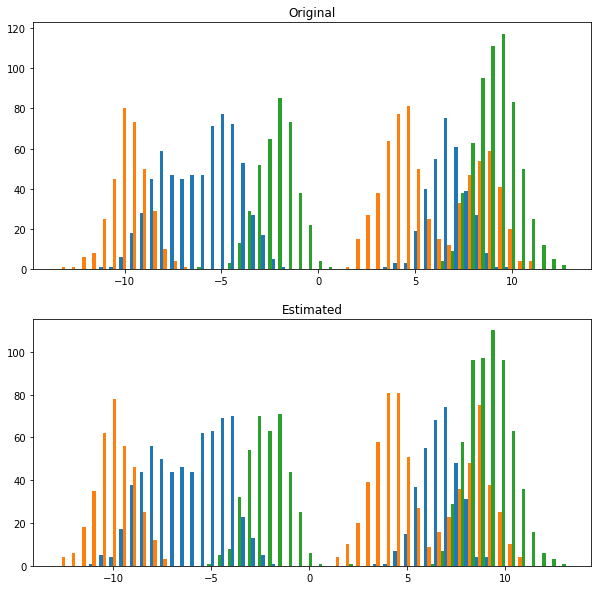

In [9]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
_ = plt.hist(X.T, bins=50, rwidth=1.0)
plt.title('Original')
plt.subplot(2, 1, 2)
_ = plt.hist(X_est.T, bins=50, rwidth=1.0)
plt.title('Estimated')
plt.show()